# Sentiment Analysis - BERT training

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
from collections import defaultdict
from textwrap import wrap
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

import wandb

import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

from imblearn.over_sampling import RandomOverSampler

### Configure

Libraries settings

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model settings

In [3]:
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'
LEN_SENTS = 100

Wandb settings to track experiment

In [5]:
#wandb.init(project="histaware")
#wandb.config.dataset = "edo_1990s"

### Import data

In [6]:
gas = pd.read_csv("sentiment/edo_1990s_gas_labeled.csv")
gas = gas[gas.energy == "Y"]
gas = gas[gas.sentiment != None]

In [7]:
olie = pd.read_csv("sentiment/edo_1990s_olie_labeled.csv")
olie = olie[olie.energy == "Y"]
olie = olie[olie.sentiment != None]

In [8]:
kool = pd.read_csv("sentiment/edo_1990s_kool_labeled.csv")
kool = kool[kool.energy == "Y"]
kool = kool[kool.sentiment_coal != None]
kool.drop(["sentiment", "sentiment_gas", "sentiment_oil"], axis=1, inplace=True)
kool.rename(columns = {"sentiment_coal": "sentiment"}, inplace=True)

In [9]:
df = pd.concat([gas, olie, kool], ignore_index=True)
df.text.replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.sentiment.replace('', np.nan, inplace=True)
df.dropna(subset=['sentiment'], inplace=True)
df.shape

(1066, 24)

### Labels

In [10]:
cleanup_sentiment = {"sentiment": {"VN": 1, "NG": 2, "NE": 3, "PO": 4, "VP": 5}}
df = df.replace(cleanup_sentiment)

Plot

In [11]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

Reduce from 5 labels to 3 because of lack of labels

In [12]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

Plot result reduction of labels

In [13]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

### Split text and explode

In [14]:
def unite(l, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = []
    chunks = []
    sents = []
    for s in l:
        count.append(len(s.split()))
    value = 0
    prev_idx = 0
    for i in range(0, len(count)):
        if value == 0:
            value = value + count[i]
        elif (i+1 == len(count)):
            chunks.append(l[prev_idx:i])
            value = 0
        elif value >= n:
            chunks.append(l[prev_idx:i])
            prev_idx = i
            value = 0
        else:
             value = value + count[i]
    for c in chunks:
        sents.append(' '.join(c))
    return(sents)

In [15]:
def splitter(s, n):
    """Split sentences only using the number of words."""
    pieces = s.split()
    return [" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n)]

In [16]:
df["text_split"] = df["text"].apply(sent_tokenize)
df["text_split"] = df["text_split"].apply(unite, n = LEN_SENTS)
df.text_split.replace([], np.nan, inplace=True)
df.dropna(subset=['text_split'], inplace=True)
# Cancel all text_split == 0
df.drop(df[df.text_split.map(len) == 0].index, inplace=True)
# Currently not splitting the cleaned sentences
#df["text_clean_split"] = df["text_clean"].apply(splitter, n = LEN_SENTS)

In [17]:
df = df[['text_split','sentiment']]

### Load Pre-trained BERT model

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Verify the max tokens length in text_split

In [19]:
MAX_LEN = 0
def max_len(x):
    lengths = []
    for i in x:
        lengths.append(len(tokenizer.encode(i.split())))
    res = max(lengths)
    return(res)
    
temp = df["text_split"].apply(max_len)
MAX_LEN = max(temp)
MAX_LEN

361

In [20]:
df = df.explode('text_split')
df.shape

(2342, 2)

In [21]:
token_lens = []
for txt in df.text_split:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


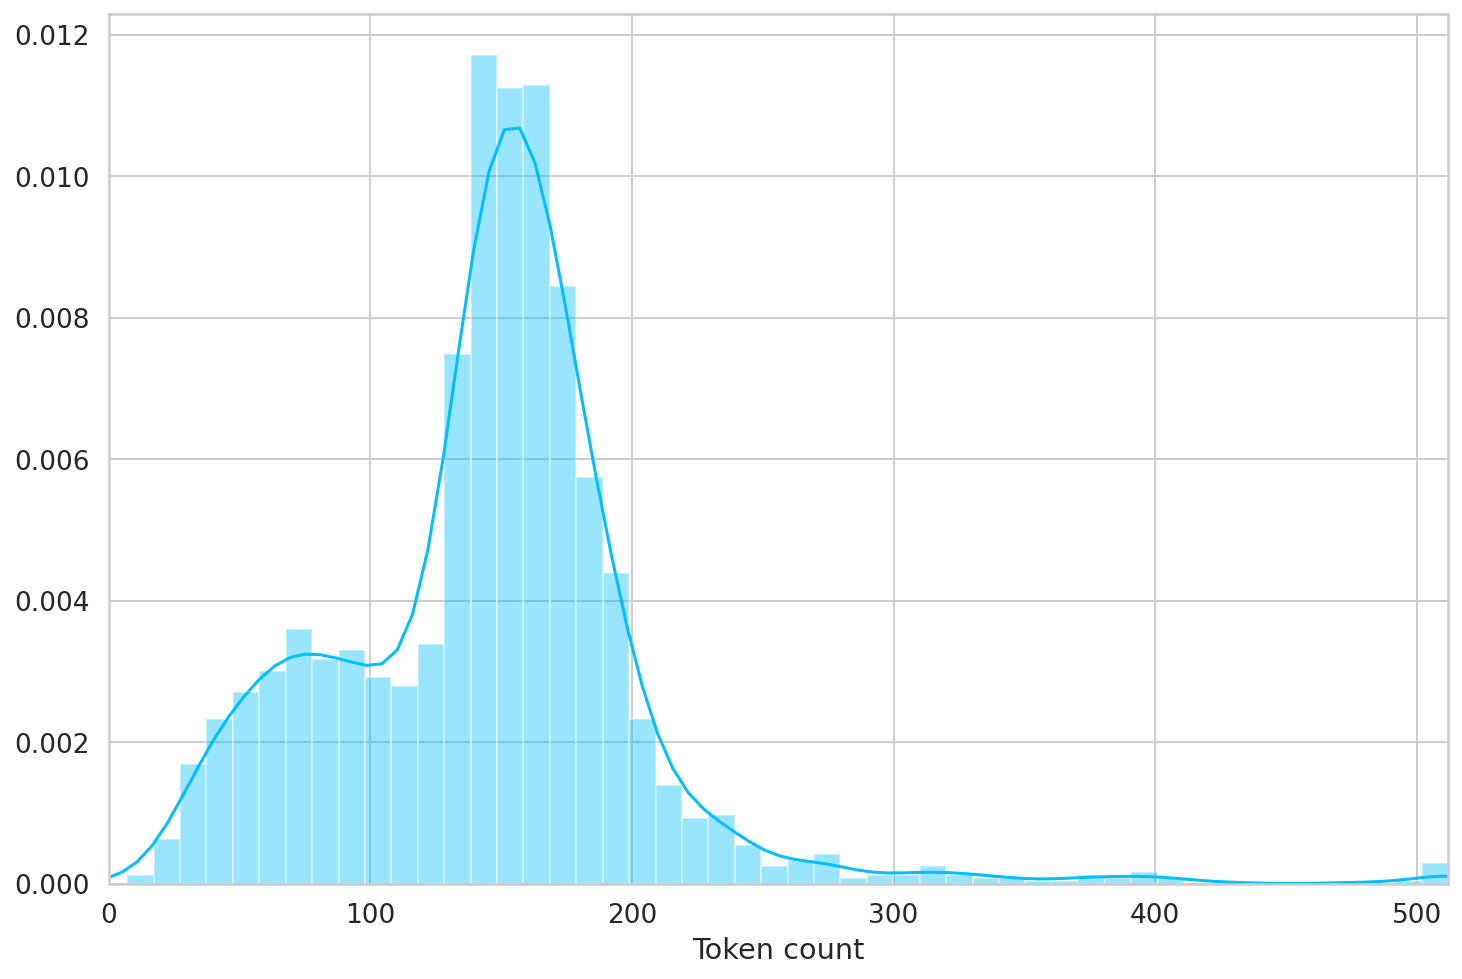

In [22]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [23]:
class HADataset(Dataset):
    # Characterizes a dataset for Pytorch
    def __init__(self, articles, labels, tokenizer, max_len):
        # Initialization
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        # Total number of articles
        return len(self.articles)

    def __getitem__(self, item):
        # Generates one sample of the data/article
        article = str(self.articles[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
          'article_text': article,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [24]:
df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [25]:
def create_data_loader(df, tokenizer, batch_size, num_workers):
    ds = HADataset(
        articles=df.text_split.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
      )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers
      )

### Use ImbSampling

In [39]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train_ros, y_train_ros = ros.fit_resample(df_train.text_split, df_train.sentiment)
X_train = pd.DataFrame(X_train_ros, columns=X_train.columns)

ValueError: Expected 2D array, got 1D array instead:
array=['Dus energiebesparing zonder energieheffing! Maar door een wet op de distributie zijn er geen gasleveringscontracten mogelijk waarin de nieuwe eigenaar het tijdstip van afname bepaalt. Dat is net zo idioot als wanneer een boer aardappelen alleen gekookt verkoopt om er zeker van te zijn dat de koper ze nog op dezelfde dag opeet.'
 'Hebben die mensen daar een groot risico gelopen? Van Krochten: „Daar wil ik liever niet op ingaan. Ik heb er wel een mening over, maar die wil ik nu niet verkondigen. De brandweer heeft daar goed en gedisciplineerd opgetreden, een grote pluim voor de Belgische overheid. Liever een hoop kosten, dan dat er één mens iets overkomt. Voor het team was er geen gevaar aan verbonden. We konden rustig werken." Hier en daar wordt gemeld dat jullie dat dorpje van de ondergang hebben gered. Wat denken jullie zelf? Van Krochten: „Ach, dan ik haal gewoon m\'n schouders op. We hebben gedaan wat we moesten doen.'
 'Waar is het plattebord van de NAM? 20 jaar hebben een half miljoen Groningers en Drenthen die meezakken met de bodemdaling door gaswinning erin geloofd. De NAM rept er in het paginagrote artikel van 26 nov. jl. niet meer over. Als u de doorsnedetekening aandachtig bekijkt zult u die ook niet zien. Wel ziet u dat van Aduard tot Grijpskerk de bodem in al die jaren stabiel is gebleven; daar werd dan ook geen gas gewonnen.'
 ...
 'Een gigant in zee. Dat is slechts een zeer beknopte omschrijving van het enorme boorplatform Troïl, dat Shell momenteel bouwt in een fjord in Noorwegen. Maar liefst 430 meter hoog moet het gevaarte worden, dat in 1995 naar zijn plaats in open zee zal worden gesleept. Deze hoogte komt overeen met bij na anderhalf keer de Eiffeltoren, ofwel ruim vier keer de Dom van Utrecht. Het gewicht van Troll spreekt bijkans nog meer tot de verbeelding. De onder meer 200.000 m 3 beton en 100.000 m 3 staal zorgen voor een totaal gewicht van ruim 700.000 ton, ongeveer wat alle Nederlanders bij elkaar wegen.'
 '"Je kunt het * arbeiders van de olieK drijven toch niet verwijte"; ze deden het voor de opboü^ van het land." Ongeve«f veertig kilometer t& noorden van Oesinsk is cc" groep van die arbeiders beftf met het opruimen van ol\'6 uit één van de kleine zijrl\' viertjes van de Petsjora. He, is een uitloper van de du\'\' zenden tonnen olie die in de afgelopen maanden zijn weg\' gelekt. Een dikke laag zwart6\' drab bedekt het wateroppe^\' vlak en de oevers van he* riviertje. Met een graafm3\' chine wordt de oliekoek opge\' schept en in een container gegooid. Waar de inhoud vaO die container vervolgens na»/ toe moet, blijken de arbei\' ders ook niet te weten. Naa* later blijkt, wordt de olie ill een put gestort enige tien tallen kilometers naar he.'
 'Kijk Wleen al naar de rente. Die in de VS op een dieptepunt, terwijl de rente bij ons luist hoog is," aldus een commissionair. : Voor Nederland lijkt het toeer van belang hoe de zaken ?lch ontwikkelen in Duitsland. Veel zal daarbij afhangen van de afloop van de loononderhandelingen van dit ment. Als de loonstijging «et boven de 6% uitkomt kan °lgens de optimisten een vaste aandelenmarkt worden verwacht. De stemming op de obligawemarkt was gisteren uitstekend. Op een gegeven moment stonden veel staatslelngen op winsten van meer 0,2 punt. Later ging er iets an de koersen af, maar per saldo werden toch winsten \'an omstreeks 0,1 punt geno, Koninklijke Olie verliet de eurs, ondanks een ruim één „e.nt lagere dollar, met een van 30 cent op f/45.30, terwijl Unilever onveranderd sloot op ƒ185,60.'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [40]:
# Parameters
batch_size = 8
num_workers = 0
max_epochs = 100

# WandB
wandb.config.batch_size = batch_size
wandb.config.num_workers = num_workers
wandb.config.max_epochs = max_epochs

# Create dataloaders
train_data_loader = create_data_loader(df_train, tokenizer, batch_size, num_workers)
val_data_loader = create_data_loader(df_val, tokenizer, batch_size, num_workers)
test_data_loader = create_data_loader(df_test, tokenizer, batch_size, num_workers)

### Example batch

In [41]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['article_text', 'input_ids', 'attention_mask', 'labels'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([8, 361])
torch.Size([8, 361])
torch.Size([8])


### Sentiment classifier

In [43]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#config.hidden_dropout_prob = 0.3

In [44]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes, PRE_TRAINED_MODEL_NAME):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [45]:
class_names = ["Negative", "Neutral", "Positive"]

In [46]:
model = SentimentClassifier(len(class_names), "wietsedv/bert-base-dutch-cased")
model = model.to(device)

### Test with one DataLoader

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 361])
torch.Size([8, 361])


In [48]:
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4843, 0.2005, 0.3152],
        [0.4421, 0.1395, 0.4184],
        [0.4575, 0.3142, 0.2283],
        [0.5574, 0.2059, 0.2368],
        [0.4394, 0.2167, 0.3439],
        [0.4462, 0.2983, 0.2555],
        [0.7037, 0.1353, 0.1610],
        [0.3718, 0.3149, 0.3134]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### BERT (re)Training

In [49]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    #wandb.log({
    #    'epoch': epoch,
    #    'loss': train_loss,
    #    'accuracy': train_acc,
    #    'val_loss': val_loss,
    #    'val_accuracy': val_acc
    #})
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        #wandb.save("best_model_state.bin")
        best_accuracy = val_acc

Epoch 1/20
----------


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 10.76 GiB total capacity; 5.86 GiB already allocated; 27.56 MiB free; 6.14 GiB reserved in total by PyTorch)

### Training history

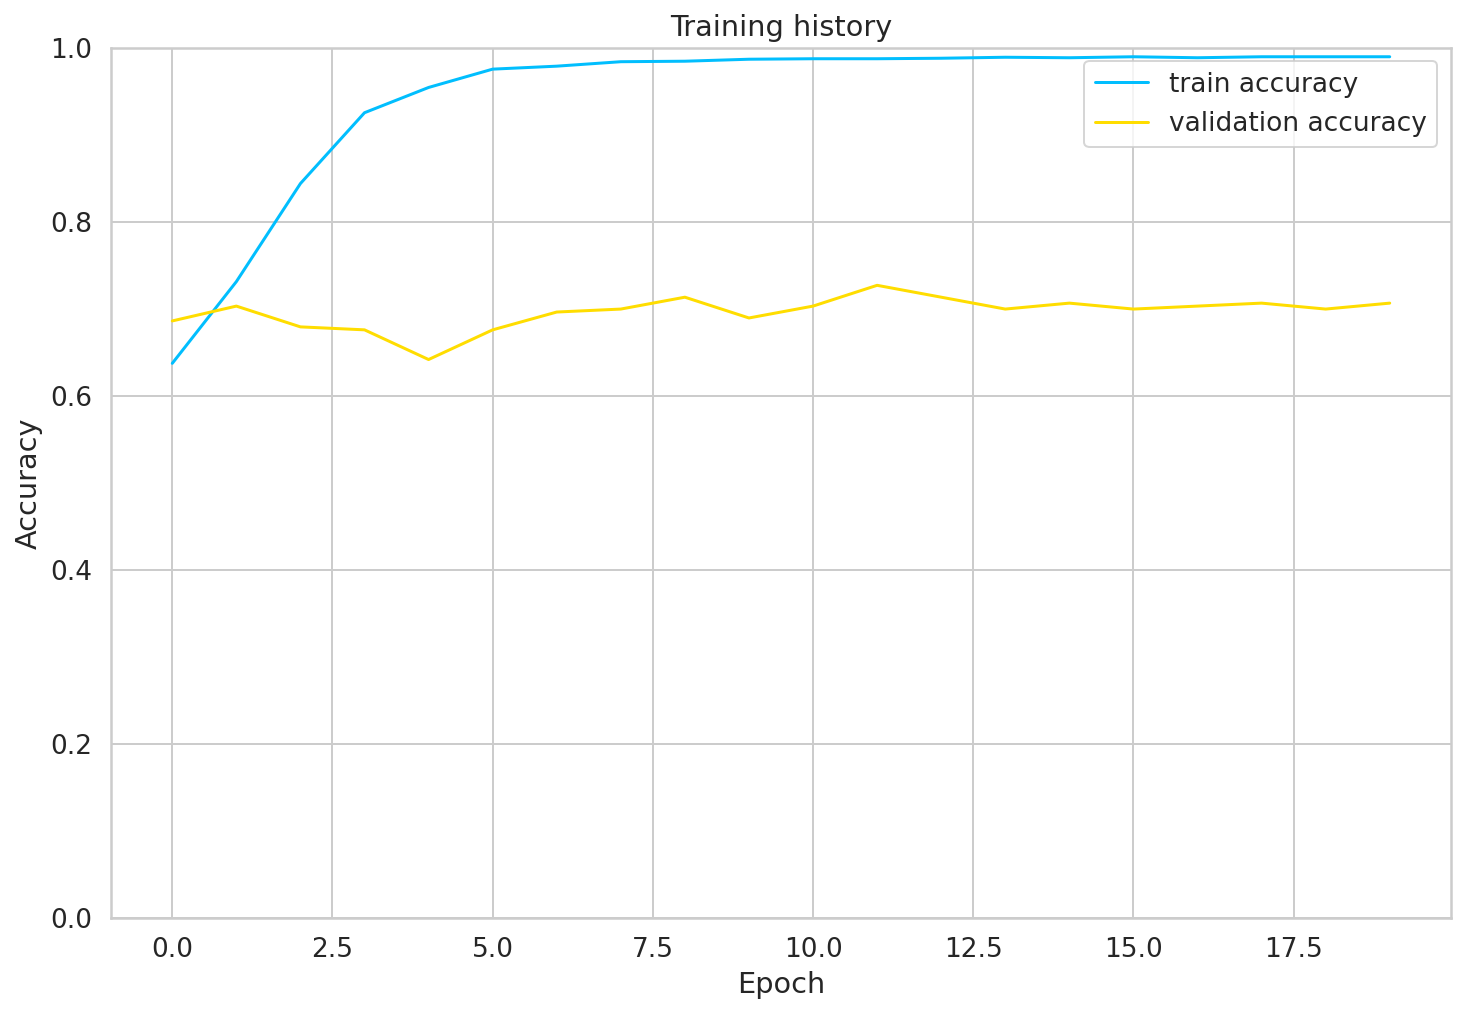

In [48]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.6928327645051194

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()
    article_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["article_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            article_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return article_texts, predictions, prediction_probs, real_values

In [40]:
y_article_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.67      0.74      0.70       100
     Neutral       0.76      0.74      0.75       164
    Positive       0.36      0.28      0.31        29

    accuracy                           0.69       293
   macro avg       0.60      0.58      0.59       293
weighted avg       0.69      0.69      0.69       293



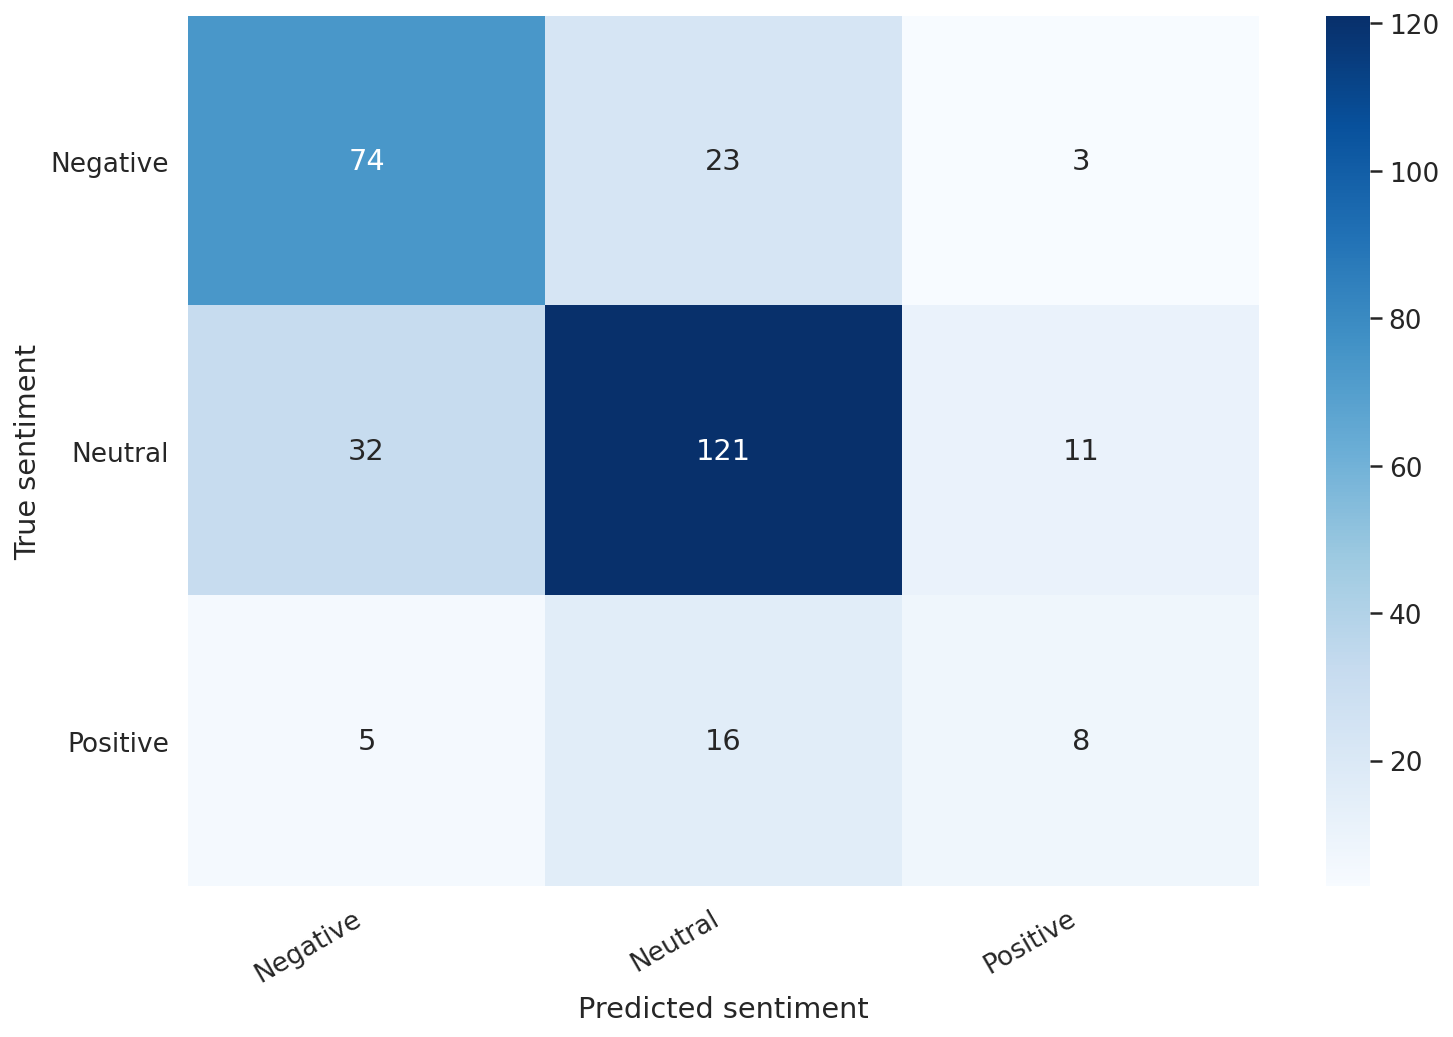

In [42]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Print example

In [43]:
idx = 2
article_text = y_article_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [44]:
print("\n".join(wrap(article_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

En dat wilden we niet.",.. ' De binnenvaartvloot van Shell, waarmee
jarenlang, de produkten vanaf de raffinaderij in Pernis naar afnemers
en depots in heel Nederland werden vervoerd, bestaat sinds kort niet
meer. Eind december werd het laatste ' schip, de Shell 4, aan de
Verenigde Tankrederij verkocht die het onder de naam Vlieland in de
vaart heeft gebracht. Hiermee eindigde een geschiedenis die# in 1902
met de ingebruikname' van een raffinaderij aan de Sluisjesdijk was
begonnen. .. Den Haan heeft die geschiedenis in de afgelopen drie jaar
vastgelegd, foto's verzameld, met gepensioneerden gesproken en
archieven doorgeplozen. Het boek was in eerste instantie bestemd voor
bij de vloot betrokken Shell-personeel en oud-medewerkers.

True sentiment: Neutral


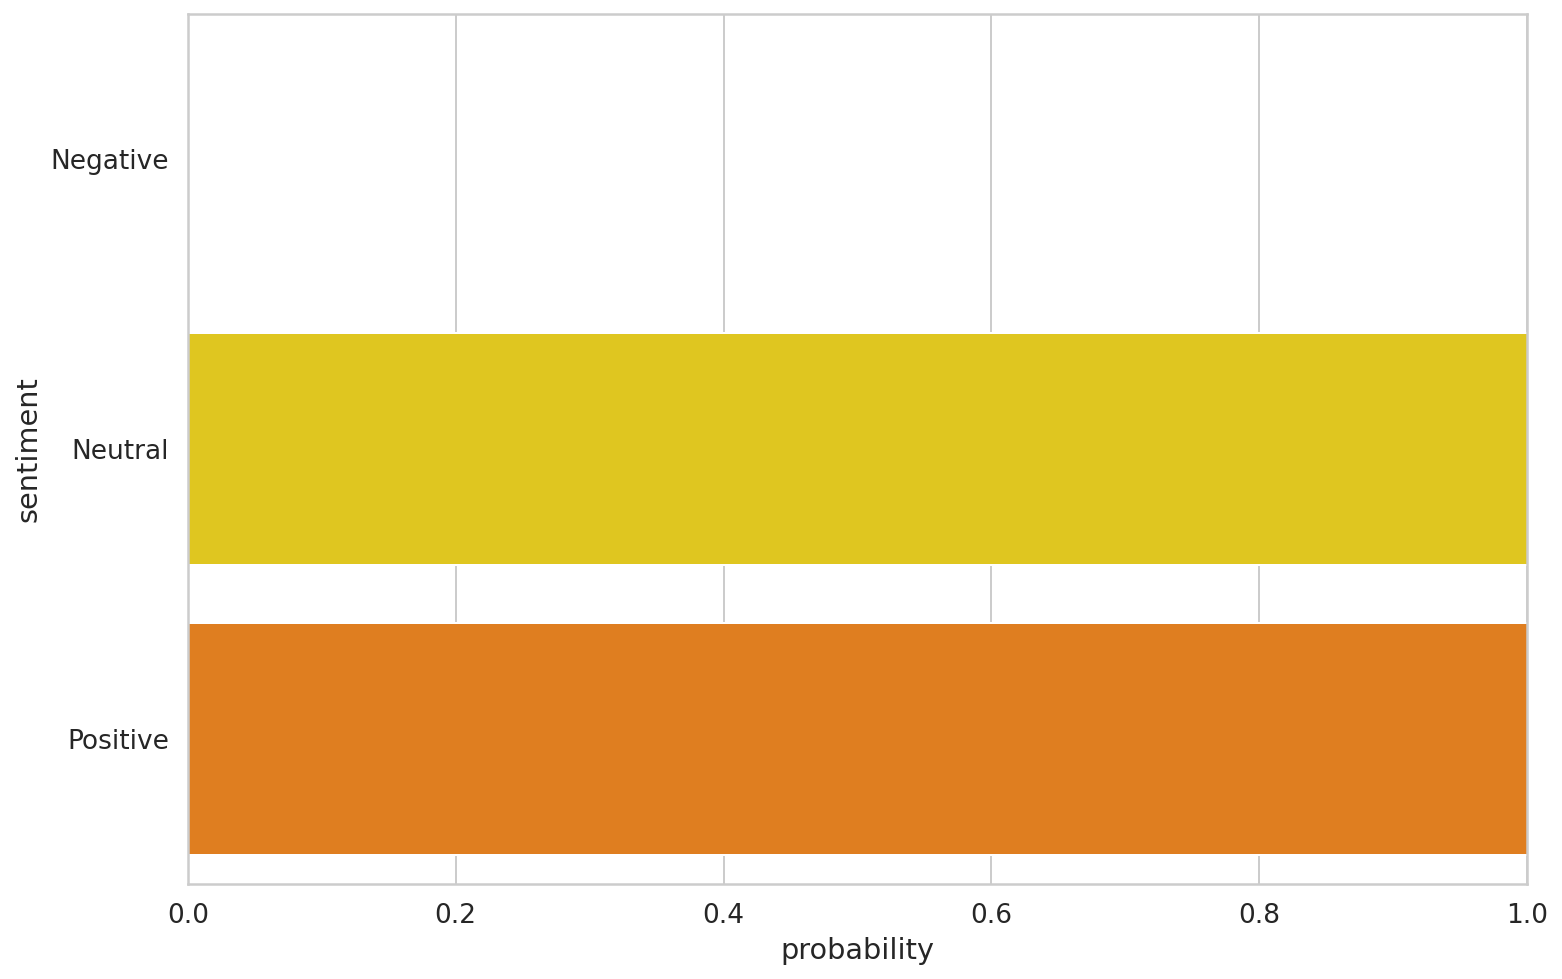

In [45]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting new articles

In [46]:
encoded_article = tokenizer.encode_plus(
    article_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/home/leonardovida/.cache/pypoetry/virtualenvs/histaware-JJpORNNs-py3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
input_ids = encoded_article['input_ids'].to(device)
attention_mask = encoded_article['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {article_text}')
print(f'Predicted sentiment: {class_names[prediction]}')
print("-----------")

Review text: En dat wilden we niet.",.. ' De binnenvaartvloot van Shell, waarmee jarenlang, de produkten vanaf de raffinaderij in Pernis naar afnemers en depots in heel Nederland werden vervoerd, bestaat sinds kort niet meer. Eind december werd het laatste ' schip, de Shell 4, aan de Verenigde Tankrederij verkocht die het onder de naam Vlieland in de vaart heeft gebracht. Hiermee eindigde een geschiedenis die# in 1902 met de ingebruikname' van een raffinaderij aan de Sluisjesdijk was begonnen. .. Den Haan heeft die geschiedenis in de afgelopen drie jaar vastgelegd, foto's verzameld, met gepensioneerden gesproken en archieven doorgeplozen. Het boek was in eerste instantie bestemd voor bij de vloot betrokken Shell-personeel en oud-medewerkers.
Predicted sentiment: Neutral
-----------
